CPU/GPU 문제가 아니라, 버전에 따라서 연산 방법 자체가 달라진 듯 하다.

1.7.1 cuda 11.0 버전에서 테스트 해야함(설치된 cuda toolkit은 11.2)

In [1]:
%load_ext lab_black
%cd ..

/home/shim/cev/dl/log-analytics


In [53]:
import argparse
import math
import multiprocessing
import sys
from datetime import datetime
from pathlib import Path
from pprint import pformat

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_optimizer
import yaml
from easydict import EasyDict
from pytorch_transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
)
from sklearn.model_selection import StratifiedKFold
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AlbertForSequenceClassification,
    AlbertTokenizer,
    DebertaForSequenceClassification,
    DebertaTokenizer,
    SqueezeBertTokenizer,
    SqueezeBertForSequenceClassification,
    XLNetTokenizer,
    XLNetForSequenceClassification,
)

from datasets import load_test_data, load_train_data, MyDataset
from utils import SAM, AverageMeter, CustomLogger, FocalLoss, seed_everything

from main import MyTrainer
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
with open("config/distilbert-base-uncased.yaml", "r") as f:
    C = EasyDict(yaml.load(f, yaml.FullLoader))
    C.result_dir = Path(C.result_dir)
    C.dataset.dir = Path(C.dataset.dir)
    seed_everything(C.seed, deterministic=False)

In [4]:
C

{'model': {'name': 'distilbert-base-uncased'},
 'comment': None,
 'result_dir': PosixPath('results/distilbert-base-uncased'),
 'debug': False,
 'seed': 20210425,
 'train': {'SAM': False,
  'folds': [4, 5],
  'checkpoints': ['results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_4.pth',
   None],
  'loss': {'name': 'focal', 'gamma': 2},
  'optimizer': {'name': 'AdamW'},
  'finetune': {'do': True, 'step1_epochs': 2, 'step2_epochs': 4},
  'max_epochs': 10,
  'lr': 1e-05,
  'scheduler': {'name': 'ReduceLROnPlateau',
   'params': {'factor': 0.5, 'patience': 3, 'verbose': True}}},
 'dataset': {'dir': PosixPath('data/ori'), 'batch_size': 30, 'num_workers': 8}}

In [5]:
trainer = MyTrainer(C, 1, "results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1.pth")

Load pretrained results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1.pth


In [6]:
model = trainer.model
model.eval()
torch.set_grad_enabled(False)

In [7]:
ds = trainer.dl_test.dataset
ds2 = trainer.dl_test2.dataset
tds = trainer.tdl.dataset
vds = trainer.vdl.dataset

In [8]:
# id, text, otext = ds2[2]
# print(id)
id, text, level, otext = vds[2111]
print(id, level)
print(otext)

r = model(text[None].cuda())[0].softmax(1)[0].cpu()
print(r, r.argmax())

10474 tensor(0)
logstash: [2020-12-28T10:53:35,263][ERROR][logstash.outputs.elasticsearch] Attempted to send a bulk request to elasticsearch, but no there are no living connections in the connection pool. Perhaps Elasticsearch is unreachable or down? {:error_message=>"No Available connections", :class=>"LogStash::Outputs::ElasticSearch::HttpClient::Pool::NoConnectionAvailableError", :will_retry_in_seconds=>64}
tensor([9.9926e-01, 1.5985e-04, 1.6344e-06, 4.6215e-04, 1.2925e-06, 1.1334e-04,
        1.5901e-06]) tensor(0)


### 각각의 level마다 confidence를 측정

In [9]:
leveldic = defaultdict(list)
confidencedic = defaultdict(list)
allconfdic = defaultdict(list)
wrongdic = defaultdict(list)
with tqdm(total=len(vds), ncols=100, file=sys.stdout) as t:
    for i, (id, text, tlevel, otext) in enumerate(vds):
        pred = model(text[None].cuda())[0].softmax(1)[0].cpu()
        confidence, plevel = pred.max(0)
        if plevel == tlevel:
            confidencedic[tlevel.item()].append(confidence.item())
        else:
            # wrong.append((i, tlevel.item()))
            wrongdic[tlevel.item()].append(
                {
                    "id": i,
                    "otext": otext,
                    "pconf": confidence.item(),
                    "plevel": plevel.item(),
                    "tconf": pred[tlevel.item()].item(),
                    "tlevel": tlevel.item(),
                }
            )

        allconfdic[tlevel.item()].append(i)
        leveldic[tlevel.item()].append(i)

        t.update()

100%|████████████████████████████████████████████████████████| 94595/94595 [08:28<00:00, 186.10it/s]


In [10]:
sorted(confidencedic.keys())

[0, 1, 2, 3, 4, 5, 6]

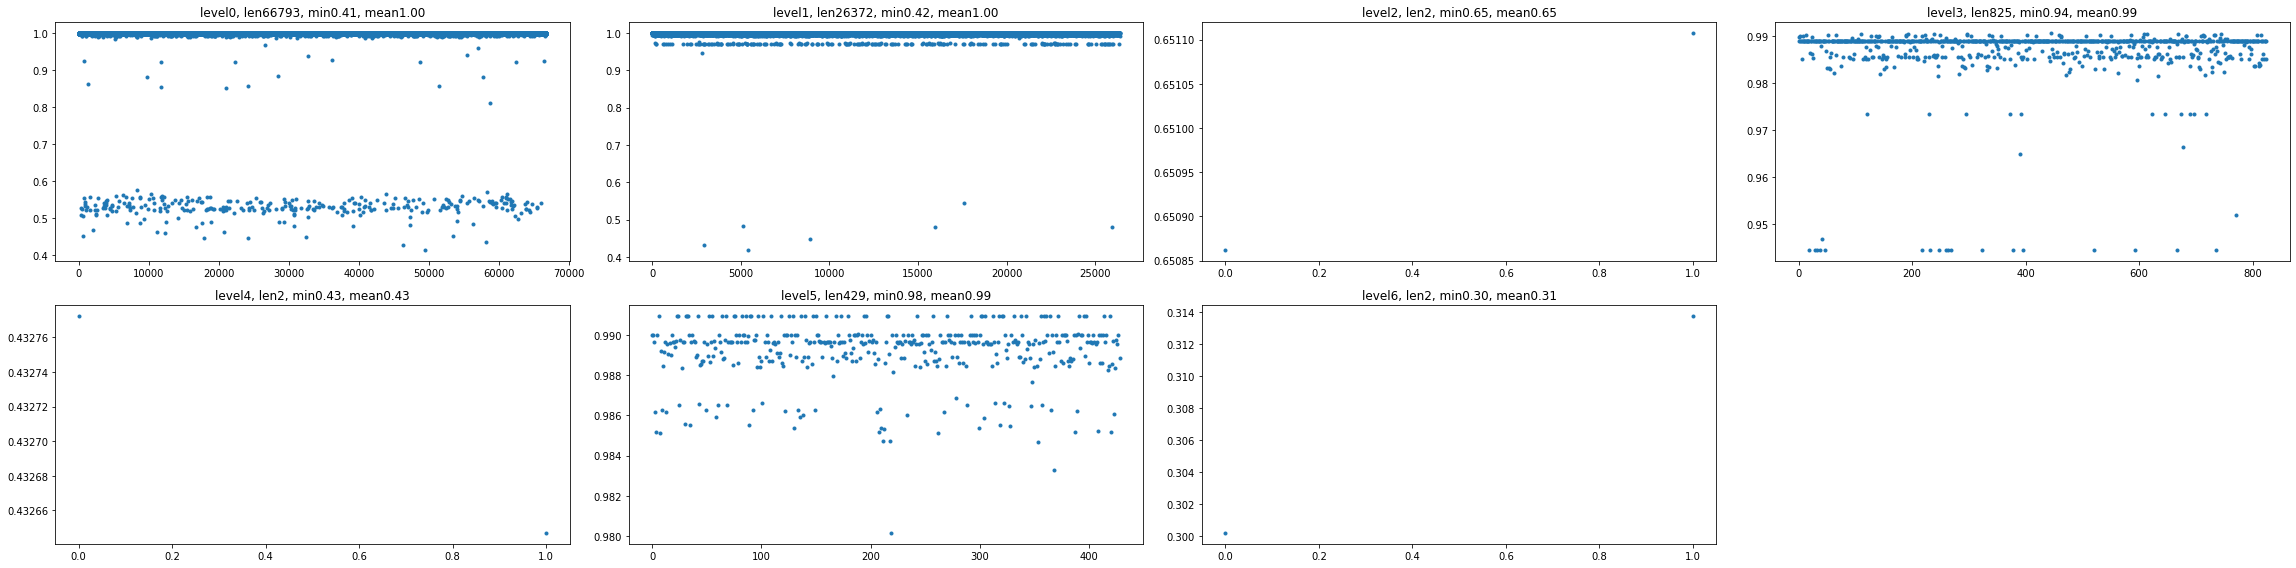

In [13]:
plt.figure(figsize=(32, 8))
for level in range(7):
    plt.subplot(2, 4, level + 1)
    plt.plot(confidencedic[level], ".")
    plt.title(
        f"level{level}, len{len(confidencedic[level])}, min{min(confidencedic[level]):.2f}, mean{sum(confidencedic[level]) / len(confidencedic[level]):.2f}"
    )
plt.tight_layout()
plt.show()

In [15]:
np.savez_compressed(
    "results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1-valid.npz",
    leveldic=leveldic,
    confidencedic=confidencedic,
    allconfdic=allconfdic,
    wrongdic=wrongdic,
)

## Confidence Threshold 분석

1. Level1이라고 예측했는데 confidence가 0.9 미만이면 level0으로 취급한다.
2. Level 2, 4, 6은 level 7이되지 않는다?
3. level2는 2에 0.5이상일 때
4. level4는 4에 0.4이상, 2에 0.1~0.2, 6에 0.1~0.2 인 경우일 때
5. level6은 6에 0.25이상, 2에 0.2 이상, 4에 0.15 이상
6. level 3 또는 5가 가장 큰데 confidence가 0.9 미만이면 level 7로 한다.
4. ??: 그 외 나머지는 level 7로 한다.

In [75]:
wrongdic[2]

[]

### Level 2

In [44]:
leveldic[2]

[68298, 75845]

In [45]:
id, text, tlevel, otext = vds[68298]

In [46]:
otext

'The average number of logs between 14:00 and 15:00 is 9734. We reached 26958.'

In [47]:
model(text[None].cuda())[0].cpu().softmax(1)[0]

tensor([0.0791, 0.0416, 0.6509, 0.0194, 0.0603, 0.0536, 0.0952])

In [48]:
id, text, tlevel, otext = vds[75845]

In [49]:
otext

'The average number of logs between 10:00 and 11:00 is 12612. We reached 31532.'

In [50]:
model(text[None].cuda())[0].cpu().softmax(1)[0]

tensor([0.0789, 0.0417, 0.6511, 0.0195, 0.0600, 0.0540, 0.0949])

---

### Level 4

In [21]:
leveldic[4]

[46002, 73775]

In [38]:
id, text, tlevel, otext = vds[46002]

In [39]:
otext

'sv260 sshd: Did not receive identification string from 192.168.0.195'

In [40]:
model(text[None].cuda())[0].cpu().softmax(1)[0]

tensor([0.0573, 0.0766, 0.1473, 0.0569, 0.4328, 0.0497, 0.1795])

In [41]:
id, text, tlevel, otext = vds[73775]

In [42]:
otext

'sv260 sshd: Did not receive identification string from 192.168.0.181'

In [43]:
model(text[None].cuda())[0].cpu().softmax(1)[0]

tensor([0.0573, 0.0766, 0.1472, 0.0571, 0.4326, 0.0497, 0.1794])

---

### Level 6

In [27]:
leveldic[6]

[34203, 85801]

In [35]:
id, text, tlevel, otext = vds[34203] # 6

In [36]:
otext

'kernel: device virbr0-nic entered promiscuous mode'

In [37]:
model(text[None].cuda())[0].cpu().softmax(1)[0]

tensor([0.0822, 0.1151, 0.2314, 0.0462, 0.1819, 0.0431, 0.3002])

In [30]:
id, text, tlevel, otext = vds[85801] # 6

In [31]:
otext

'kernel: device enp2s0 entered promiscuous mode'

In [34]:
model(text[None].cuda())[0].cpu().softmax(1)[0]

tensor([0.0775, 0.0860, 0.2301, 0.0488, 0.2026, 0.0412, 0.3138])

## Level 7 Validation

In [51]:
df = pd.read_csv("data/ori/validation_sample.csv")

In [52]:
df

,full_log
0,type=ANOM_PROMISCUOUS msg=audit(1600402733.466...
1,"oscap: msg: ""xccdf-result"", scan-id: ""00016007..."
2,Sep 22 10:56:19 localhost kernel: Out of memor...


In [57]:
ds_test2 = MyDataset(trainer.tokenizer, np.arange(3), df.full_log)

In [71]:
id, text, otext = ds_test2[0]
print(otext)
print()
print(model(text[None].cuda())[0].cpu().softmax(1)[0])

type=ANOM_PROMISCUOUS msg=audit(1600402733.466:4503): dev=enp2s0 prom=256 old_prom=0 auid=4294967295 uid=0 gid=0 ses=4294967295 type=SYSCALL msg=audit(1600402733.466:4503): arch=c000003e syscall=54 success=yes exit=0 a0=c a1=107 a2=1 a3=7f856aed1140 items=0 ppid=1 pid=12152 auid=4294967295 uid=0 gid=0 euid=0 suid=0 fsuid=0 egid=0 sgid=0 fsgid=0 tty=(none) ses=4294967295 comm="W#01-enp2s0" exe="/usr/sbin/suricata" subj=system_u:system_r:unconfined_service_t:s0 key=(null) type=PROCTITLE msg=audit(1600402733.4

tensor([5.1793e-04, 9.9919e-01, 1.9581e-05, 7.2380e-05, 6.2770e-06, 1.8629e-04,
        6.9159e-06])


In [73]:
id, text, otext = ds_test2[1]
print(otext)
print()
print(model(text[None].cuda())[0].cpu().softmax(1)[0])

oscap: msg: "xccdf-result", scan-id: "0001600739632", content: "ssg-centos-7-ds.xml", title: "Prevent Log In to Accounts With Empty Password", id: "xccdf_org.ssgproject.content_rule_no_empty_passwords", result: "fail", severity: "high", description: "If an account is configured for password authentication but does not have an assigned password, it may be possible to log into the account without authentication. Remove any instances of the nullok option in /etc/pam.d/system-auth to prevent logins with empty p

tensor([1.1233e-02, 6.1638e-03, 7.1812e-05, 9.8047e-01, 9.9402e-05, 1.8695e-03,
        9.3332e-05])


In [69]:
id, text, otext = ds_test2[2]
print(otext)
print()
print(model(text[None].cuda())[0].cpu().softmax(1)[0])

kernel: Out of memory: Kill process 1736 (probe_rpmverify) score 243 or sacrifice child

tensor([9.6792e-01, 9.7140e-03, 7.9589e-04, 1.4775e-02, 6.3854e-04, 5.3858e-03,
        7.7351e-04])


## softmax 없이

In [79]:
tlevell = []
plevell = []
with tqdm(total=len(vds), ncols=100, file=sys.stdout) as t:
    for ids, texts, tlevels, otexts in trainer.vdl:
        plevels = model(texts.cuda())[0].cpu()
        plevell.append(plevels)
        tlevell.append(tlevels)
        t.update(len(ids))

100%|████████████████████████████████████████████████████████| 94595/94595 [08:31<00:00, 185.10it/s]


In [88]:
tlevels = torch.cat(tlevell)
plevels = torch.cat(plevell)
tlevels.shape, plevels.shape

(torch.Size([94595]), torch.Size([94595, 7]))

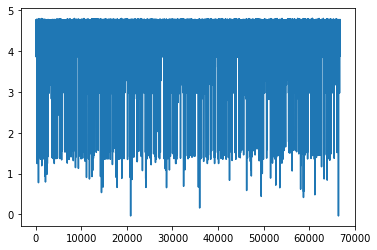

In [102]:
plt.plot(plevels[tlevels == 0][:, 0])

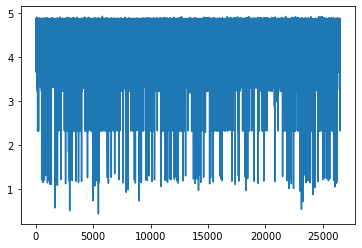

In [103]:
plt.plot(plevels[tlevels == 1][:, 1])

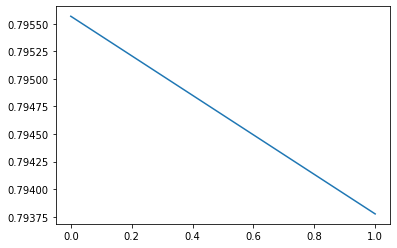

In [104]:
plt.plot(plevels[tlevels == 2][:, 2])

In [105]:
plevels[tlevels == 2]

tensor([[-1.3127, -1.9549,  0.7956, -2.7154, -1.5842, -1.7009, -1.1272],
        [-1.3164, -1.9554,  0.7938, -2.7148, -1.5907, -1.6961, -1.1326]])

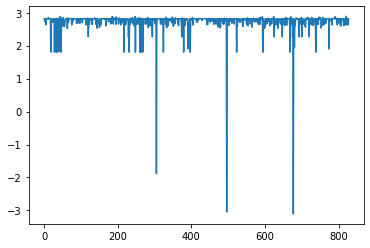

In [106]:
plt.plot(plevels[tlevels == 3][:, 3])

In [109]:
plevels[tlevels == 3][plevels[tlevels == 3][:, 3] < 0]

tensor([[ 1.4565, -2.0135, -4.4232, -1.8826, -4.7498, -3.4014, -4.3885],
        [ 1.4047,  1.1766, -7.5787, -3.0441, -7.9432, -1.1667, -7.8078],
        [ 1.4629,  1.2245, -7.8150, -3.1048, -8.2012, -1.2295, -8.0719]])

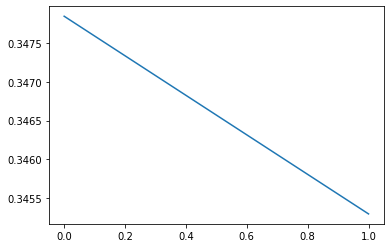

In [110]:
plt.plot(plevels[tlevels == 4][:, 4])

In [111]:
plevels[tlevels == 4]

tensor([[-1.6737, -1.3841, -0.7297, -1.6819,  0.3478, -1.8172, -0.5322],
        [-1.6758, -1.3860, -0.7329, -1.6791,  0.3453, -1.8191, -0.5353]])

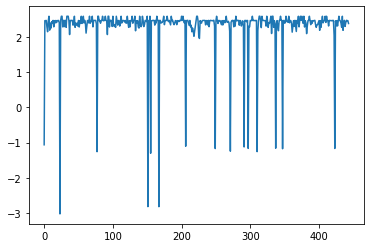

In [112]:
plt.plot(plevels[tlevels == 5][:, 5])

In [115]:
plevels[tlevels == 5][plevels[tlevels == 5][:, 5] < 0]

tensor([[ 1.3124,  1.1073, -7.2920, -2.9590, -7.6342, -1.0644, -7.5031],
        [ 1.8367, -2.6057, -4.5536, -2.0836, -4.7156, -3.0276, -4.5266],
        [ 1.5196,  1.2278, -7.9593, -3.1470, -8.3555, -1.2610, -8.2169],
        [-2.1902, -1.6925, -3.9634,  0.1019, -3.6263, -2.8208, -3.6047],
        [ 1.5678,  1.2902, -8.1998, -3.2480, -8.6114, -1.3041, -8.4803],
        [-2.1907, -1.6900, -3.9668,  0.1019, -3.6288, -2.8228, -3.6072],
        [ 1.3707,  1.1084, -7.3612, -2.9855, -7.7199, -1.1050, -7.5773],
        [ 1.3724,  1.1985, -7.5151, -3.0250, -7.8929, -1.1719, -7.7563],
        [ 1.5035,  1.2382, -7.9050, -3.1550, -8.3072, -1.2457, -8.1643],
        [ 1.3629,  1.1514, -7.4160, -3.0085, -7.7782, -1.1266, -7.6487],
        [ 1.4211,  1.1784, -7.6620, -3.0843, -8.0351, -1.1670, -7.8941],
        [ 1.5525,  1.2309, -8.0383, -3.2053, -8.4424, -1.2595, -8.3014],
        [ 1.4267,  1.1437, -7.6350, -3.0419, -7.9943, -1.1613, -7.8679],
        [ 1.4020,  1.2234, -7.6624, -3.0962, -8.042

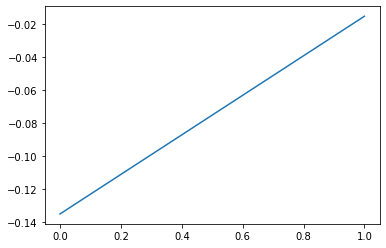

In [113]:
plt.plot(plevels[tlevels == 6][:, 6])

## Submission softmax 없이

In [80]:
preds = []
with tqdm(total=len(trainer.dl_test.dataset), ncols=100, file=sys.stdout) as t:
    for id, text, otext in trainer.dl_test:
        pred = model(text.cuda())[0].cpu()
        preds.append(pred)
        t.update(len(id))

100%|██████████████████████████████████████████████████| 1418916/1418916 [2:34:23<00:00, 153.18it/s]


## Submission

그냥 fold1 distil bert로 submission(level 7은 무시)을 만들면 어느정도 정확도가 나올까?

In [9]:
preds = []
with tqdm(total=len(trainer.dl_test.dataset), ncols=100, file=sys.stdout) as t:
    for id, text, otext in trainer.dl_test:
        pred = model(text.cuda())[0].softmax(1).cpu()
        preds.append(pred)
        # break
        t.update(len(id))

100%|██████████████████████████████████████████████████| 1418916/1418916 [1:12:59<00:00, 324.00it/s]


In [10]:
preds[0].shape

torch.Size([30, 7])

In [11]:
ps = torch.cat(preds, dim=0)

In [12]:
ps.shape

torch.Size([1418916, 7])

In [15]:
plevel = ps.argmax(dim=1)

In [16]:
plevel.shape

torch.Size([1418916])

In [17]:
j = 1000
plevel[j : j + 100]

tensor([0, 0, 0, 1, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0])

In [18]:
data = {"id": list(range(1000000, 2418915 + 1)), "level": plevel.tolist()}

In [19]:
df = pd.DataFrame(data)

In [20]:
df

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [21]:
for i in range(7):
    print((plevel == i).sum().item())

1003860
395602
34
13063
34
6293
30


In [23]:
df.to_csv("results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1.csv", index=False)

In [25]:
ps_np = ps.numpy()

In [26]:
np.savez_compressed("results/distilbert-base-uncased/distilbert-base-uncased-focal-AdamW-lr1e-05_1.npz", ps=ps_np)

## 정확도

### 그냥 정확도

In [58]:
cnt = 0
for i in range(7):
    cnt += len(wrongdic[i])

In [63]:
vacc = 1 - cnt / len(vds)

In [64]:
vacc

0.998202864844865

### 1인데 1의 confidence랑 0의 confidence의 차가 0.5 이하면 0이라고 했을 때 정확도는?

In [71]:
d = wrongdic[1][4]
abs(d["pconf"] - d["tconf"])

0.10417789220809937

### MEMO

level 0, 1은 99% 정도의 높은 confidence를 보이는 반면, level 2는 validation에도 2개의 데이터밖에 없기 때문에 65%의 confidence가 나온다.

valid idx 68298, 75845

- level별로 confidence threshold가 천차만별일 듯 하다.  
- level별로 validation을 진행하고 confidence의 목록을 만들어서 확인해보자!!

### 결과 만들기

- 0이랑 1 사이에서 고문하는 경우도 --> |conf[0] - conf[1]| < 0.1 일 경우  
1을 0으로 착각한건 20개, 0을 1로 착간한건 132개. 그러므로 위의 경우에는 0으로 결정하는게 좋겠다.

- fold1에서 2~6까지는 틀린게 하나도 없었음. (물론 데이터 수도 적었지만)

### 정책

- 